In [15]:
# Initialize Otter
import otter
grader = otter.Notebook("lab10.ipynb")

# Lab 10: SQL

In this lab, we are going to practice viewing, sorting, grouping, and merging tables with SQL. We will explore two datasets:
1. A "minified" version of the [Internet Movie Database](https://www.imdb.com/interfaces/) (IMDb). This SQLite database (~10MB) is a tiny sample of the much larger database (more than a few GBs). As a result, disclaimer that we may get wildly different results than if we use the whole database!

1. The money donated during the 2016 election using the [Federal Election Commission (FEC)'s public records](https://www.fec.gov/data/). You will be connecting to a SQLite database containing the data. The data we will be working with in this lab is quite small (~16MB); however, it is a sample taken from a much larger database (more than a few GBs).


The on-time deadline is **Tuesday, November 7th at 11:59 PM PT**. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted.

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** the walkthrough video is from Spring 2022, where the format of answers was different than it is this semester.

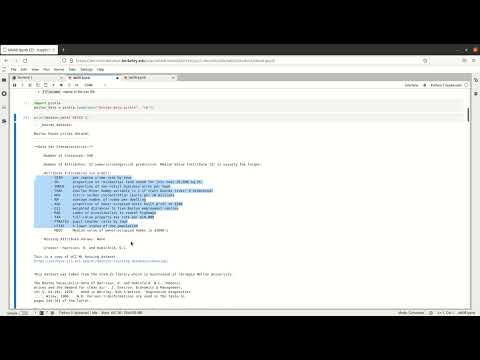

In [16]:
from IPython.display import YouTubeVideo
YouTubeVideo("uQ3E4pejmD8", list = 'PLQCcNQgUcDfpdBnhS-lPq8LPas48tkMgp', listType = 'playlist')

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

In [17]:
# Run this cell and the next one to set up your notebook.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
import sqlalchemy
from pathlib import Path
from zipfile import ZipFile

with ZipFile('data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [18]:
# Run this cell to set up SQL. You can ignore any 
# yellow messages that pop up when running this cell
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [19]:
# Run this cell to set up the autograder
from sql_utils import * 
from pathlib import Path
Path("results").mkdir(parents=True, exist_ok=True)

## SQL Query Syntax

Throughout this lab, you will become familiar with the following syntax for the `SELECT` query:

```
SELECT <column list>
FROM <table>
[WHERE <predicate>]
[GROUP BY <column list>]
[HAVING <predicate>]
[ORDER BY <column list>]
[LIMIT <number of rows>]
[OFFSET <number of rows>]
```

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Part 0 [Tutorial]: Writing SQL in Jupyter Notebooks

### 1. `%%sql` cell magic

In lecture, we used the `sqlalchemy` extension to use **`%%sql` cell magic**, which enables us to connect to SQL databases and issue SQL commands within Jupyter Notebooks.

Run the below cell to connect to a mini IMDb database.

In [20]:
from pathlib import Path
import shutil
import pathlib

# Do not modify following lines.

# These lines specify the location of our database file
imdbfile = 'imdbmini.db'
tmpimdb = Path('.') / imdbfile

# Specify the database connection path (in this case, a sqlite database in a file)
imdb_sqlite_conn = 'sqlite:///' + str(tmpimdb)

# Create an SQLAlchemy engine to connect to the database
imdb_engine = sqlalchemy.create_engine(imdb_sqlite_conn)

The above cell connects to the same database using the SQLAlchemy Python library, which can connect to several different database management systems, including sqlite3, MySQL, PostgreSQL, and Oracle. The library also supports an advanced feature for generating queries called an [object relational mapper](https://docs.sqlalchemy.org/en/latest/orm/tutorial.html) or ORM, which we won't discuss in this course but is quite useful for application development.

In [21]:
# Plug the SQLAlchemy engine into line magic to establish a connection
%sql imdb_engine

Above, prefixing our single-line command with `%sql` means that the entire line will be treated as a SQL command (this is called "line magic"). In this class we will most often write multi-line SQL, meaning we need "cell magic", where the first line has `%%sql` (note the double `%` operator).

The database `imdbmini.db` includes several tables, one of which is `Name`. Running the below cell will return first 5 lines of that table. Note that `%%sql` is on its own line.

We've also included syntax for single-line comments, which are surrounded by `--`, and multi-line comments, which are surrounded by `/*` and `*/`.

In [22]:
%%sql
/*
 * This is a
 * multi-line comment.
 */
-- This is a single-line/inline comment. --
SELECT *
FROM Name
LIMIT 5;

Running query in 'sqlite:///imdbmini.db'

nconst,primaryName,birthYear,deathYear,primaryProfession
1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
2,Lauren Bacall,1924,2014,"actress,soundtrack"
3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
4,John Belushi,1949,1982,"actor,soundtrack,writer"
5,Ingmar Bergman,1918,2007,"writer,director,actor"


<br/>

### 2. The `pandas` command `pd.read_sql`

This section describes how data scientists use SQL and `python` in practice, using the `pandas` command `pd.read_sql` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html)). **You will see both `%sql` magic and `pd.read_sql` in this course**.

With the SQLAlchemy object `engine`, we can call `pd.read_sql` which takes in a `query` **string**. Note the `"""` to define our multi-line string, which allows us to have a query span multiple lines. The resulting `DataFrame` `df` stores the results of the same SQL query from the previous section.

In [23]:
# Run this cell to see the demo.
query = """
SELECT *
FROM Name
LIMIT 5;
"""

df = pd.read_sql(query, imdb_engine)
df

,nconst,primaryName,birthYear,deathYear,primaryProfession
0,1,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
1,2,Lauren Bacall,1924,2014,"actress,soundtrack"
2,3,Brigitte Bardot,1934,None,"actress,soundtrack,music_department"
3,4,John Belushi,1949,1982,"actor,soundtrack,writer"
4,5,Ingmar Bergman,1918,2007,"writer,director,actor"


#### `pd.read_sql` vs. `%sql` magic error messages

`pd.read_sql` has **long error messages**: Given that the SQL query is now in the string, the errors become more unintelligible. Consider the below (incorrect) query.

**Note**: Uncomment the below code and check out the error. You can uncomment/comment out multiple cells at the same time by selecting the lines and press ctrl+/ or command+/ 

In [24]:
# Uncomment the below code and check out the error.
# query = """
# SELECT *
# FROM Title;
# LIMIT 5
# """
# pd.read_sql(query, imdb_engine)

<br/>
<details>
<summary>Now that's an unruly error message! Can you see what's wrong in the cell above and correct the query? Toggle this cell to check your answer!</summary>
It has a semicolon in the wrong place!
</details>

<br/>

On the other hand, `%sql` magic gives more intelligible error messages, so we will use this format more often.

In [25]:
# %%sql
# -- Uncomment the code and check out the error. --
# SELECT *
# FROM Title;
# LIMIT 5

<br/>
<!-- 
TODO

### 3. A suggested workflow for writing SQL in Jupyter Notebooks

Which approach is better, `%sql` magic or `pd.read_sql`?

The SQL database generally contains much more data than what you would analyze in detail. As a `python`-fluent data scientist, you will often query SQL databases to perform initial exploratory data analysis, a subset of which you load into `python` for further processing.

In practice, you would likely use a combination of the two approaches. First, you'd try out some SQL queries with `%sql` magic to get an interesting subset of data. Then, you'd copy over the query into a `pd.read_sql` command for visualization, modeling, and export with `pandas`, sklearn, and other `python` libraries.

For SQL assignments in this course, to minimize unruly error messages while maximizing `python` compatibility, we suggest the following "sandboxed" workflow:
1. Create a `%%sql` magic cell using the code below. 

    ```
    %% sql
    -- This is a comment. Put your code here... --
    ```
    
<br/>

2. Work on the SQL query in the `%%sql` cell; e.g., `SELECT ... ;`
3. Then, once you're satisfied with your SQL query, copy it into the multi-string query in the answer cell (the one that contains the `pd.read_sql` call).

You don't have to follow the above workflow to get full credit on assignments, but we suggest it to reduce debugging headaches. We've created the scratchwork `%%sql` cells for you in this assignment—but **if you add any cells, please delete them before submitting**. Newly added cells will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file. -->


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: The IMDb (mini) Dataset

Let's explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we will use for the upcoming homework. We'll load it in using cell magic.

In [26]:
imdb_engine = sqlalchemy.create_engine(imdb_sqlite_conn)

In [27]:
%sql imdb_engine

In [28]:
%%sql
SELECT * FROM sqlite_master WHERE type='table';

Running query in 'sqlite:///imdbmini.db'

type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details open>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema.</summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (integer) - alphanumeric unique identifier of the name/person
- primaryName (text)– name by which the person is most often credited
- birthYear (text) – in YYYY format
- deathYear (text) – in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- ordering (text) – a number to uniquely identify rows for a given tconst
- nconst (integer) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and votes information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the filmmakers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- Year (text) – represents the release year of a title.
- runtimeMinutes (text)  – primary runtime of the title, in minutes
    
</details>

<br/><br/>

From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* that `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>

---

## Question 1

What are the different kinds of `titleType`s included in the `Title` table? Write a query to find out all the unique `titleType`s of films using the `DISTINCT` keyword.  (**You may not use `GROUP BY`.**)

In [29]:
# run this cell to make sure we're using the IMDB dataset
%sql imdb_engine 

In [30]:
%%sql --save query_1 result_1 <<
SELECT DISTINCT titleType
    FROM Title;

Running query in 'sqlite:///imdbmini.db'

In [31]:
# Run this cell before running the autograder; no further action is needed
query_1 = %sqlcmd snippets query_1
save_results("result_1", query_1, result_1)
result_1

titleType
short
movie
tvSeries
tvMovie
tvMiniSeries
video
videoGame
tvEpisode
tvSpecial


In [43]:
grader.check("q1")

q1 results: All test cases passed!

<br><br>

---

## Question 2

Before we proceed we want to get a better picture of the kinds of jobs that exist.  To do this examine the `Role` table by computing the number of records with each job `category`.  Present the results in descending order by the total counts.

The top of your table should look like this (however, you should have more rows):

| |category|total|
|-----|-----|-----|
|**0**|actor|21665|
|**1**|writer|13830|
|**2**|...|...|

In [33]:
# run this cell to make sure we're using the IMDB dataset
%sql imdb_engine 

In [66]:
%%sql --save query_2 result_2 <<
SELECT category, COUNT(*) AS total
FROM Role
GROUP BY category
ORDER BY total DESC;

Running query in 'sqlite:///imdbmini.db'

In [67]:
# Run this cell before running the autograder; no further action is needed
query_2 = %sqlcmd snippets query_2
save_results("result_2", query_2, result_2)
result_2

category,total
actor,21665
writer,13830
actress,12175
producer,11028
director,6995
composer,4123
cinematographer,2747
editor,1558
self,623
production_designer,410


In [68]:
grader.check("q2")

q2 results: All test cases passed!

<br/>
If we computed the results correctly we should see a nice horizontal bar chart of the counts per category below:

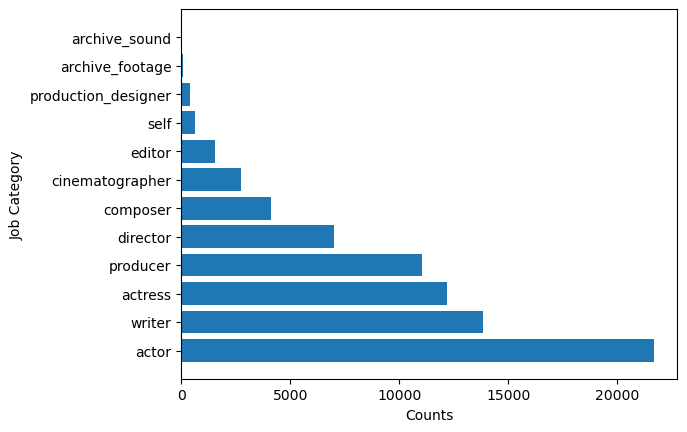

In [69]:
# Run this cell to make a bar plot.
res_q2 = result_2.DataFrame() # turn our SQL query to a DataFrame
plt.barh(res_q2["category"], res_q2["total"])
plt.xlabel("Counts")
plt.ylabel("Job Category");

<br/><br/>

---

## Question 3

Now that we have a better sense of the basics of our data, we can ask some more interesting questions.

The `Rating` table has the `numVotes` and the `averageRating` for each title. Which 10 films have the most ratings?

Write a SQL query that outputs three fields: the `title`, `numVotes`, and `averageRating` for the 10 films that have the highest number of ratings.  Sort the result in descending order by the number of votes.

**Hint**: The `numVotes` in the `Rating` table is not an integer! Use `CAST(Rating.numVotes AS int) AS numVotes` to convert the attribute to an integer. Sometimes SQL will cast your data automatically when performing operation, but you should cast them explicitly for readability and reproducibility.

In [77]:
# run this cell to make sure we're using the IMDB dataset
%sql imdb_engine 

In [84]:
%%sql --save query_3 result_3 <<
SELECT primaryTitle AS title, CAST(Rating.numVotes AS int) AS numVotes, averageRating
FROM Rating
JOIN Title
ON Rating.tconst = Title.tconst
ORDER BY numVotes DESC
LIMIT 10;

Running query in 'sqlite:///imdbmini.db'

In [85]:
# Run this cell before running the autograder; no further action is needed
query_3 = %sqlcmd snippets query_3
save_results("result_3", query_3, result_3)
result_3

title,numVotes,averageRating
The Shawshank Redemption,2462686,9.3
The Dark Knight,2417875,9.0
Inception,2169255,8.8
Fight Club,1939312,8.8
Pulp Fiction,1907561,8.9
Forrest Gump,1903969,8.8
Game of Thrones,1874040,9.2
The Matrix,1756469,8.7
The Lord of the Rings: The Fellowship of the Ring,1730296,8.8
The Lord of the Rings: The Return of the King,1709023,8.9


In [86]:
grader.check("q3")

q3 results: All test cases passed!

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Election Donations in New York City

Finally, let's analyze the Federal Election Commission (FEC)'s public records. We connect to the database using cell magic so that we can flexibly explore the database.

In [87]:
# These lines specify the location of our database file
fec_dbfile = 'fec_nyc.db'
fec_tmpdb = Path('.') / fec_dbfile

# Specify SQLAlchemy Connection URL so line/cell magic can talk to database
fec_sqlite_conn = 'sqlite:///' + str(fec_tmpdb)

# Create a SQLAlchemy engine to connect to the database.
fec_engine = sqlalchemy.create_engine(fec_sqlite_conn)

# Plug connection url into line magic to establish connection
%sql fec_engine

### Table Descriptions

Run the below cell to explore the **schemas** of all tables saved in the database.

If you'd like, you can consult the below linked FEC pages for the descriptions of the tables themselves.

* `cand` ([link](https://www.fec.gov/campaign-finance-data/candidate-summary-file-description/)): Candidates table. Contains names and party affiliation.
* `comm` ([link](https://www.fec.gov/campaign-finance-data/committee-summary-file-description/)): Committees table. Contains committee names and types.
* `indiv_sample_nyc` ([link](https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description)): All individual contributions from New York City .

In [88]:
%%sql
/* just run this cell */
SELECT sql FROM sqlite_master WHERE type='table';

Running query in 'sqlite:///fec_nyc.db'

sql
"CREATE TABLE ""cand"" ( cand_id character varying(9), cand_name text, cand_pty_affiliation character varying(3), cand_election_yr integer, cand_office_st character varying(2), cand_office character(1), cand_office_district integer, cand_ici character(1), cand_status character(1), cand_pcc character varying(9), cand_st1 text, cand_st2 text, cand_city text, cand_st character varying(2), cand_zip character varying(10))"
"CREATE TABLE ""comm""( ""cmte_id"" TEXT, ""cmte_nm"" TEXT, ""tres_nm"" TEXT, ""cmte_st1"" TEXT, ""cmte_st2"" TEXT, ""cmte_city"" TEXT, ""cmte_st"" TEXT, ""cmte_zip"" TEXT, ""cmte_dsgn"" TEXT, ""cmte_tp"" TEXT, ""cmte_pty_affiliation"" TEXT, ""cmte_filing_freq"" TEXT, ""org_tp"" TEXT, ""connected_org_nm"" TEXT, ""cand_id"" TEXT)"
"CREATE TABLE indiv_sample_nyc ( cmte_id character varying(9), amndt_ind character(1), rpt_tp character varying(3), transaction_pgi character(5), image_num bigint, transaction_tp character varying(3), entity_tp character varying(3), name text, city text, state character(2), zip_code character varying(12), employer text, occupation text, transaction_dt character varying(9), transaction_amt integer, other_id text, tran_id text, file_num bigint, memo_cd text, memo_text text, sub_id bigint)"


<br/><br/>

Let's look at the `indiv_sample_nyc` table. The below cell displays individual donations made by residents of the state of New York. We use `LIMIT 5` to avoid loading and displaying a huge table.

In [89]:
%%sql
/* just run this cell */
SELECT *
FROM indiv_sample_nyc
LIMIT 5;

Running query in 'sqlite:///fec_nyc.db'

cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
C00445015,N,Q1,P,15951128130,15,IND,"SINGER, TRIPP MR.",NEW YORK,NY,100214505,"ATLANTIC MAILBOXES, INC.",OWNER,01302015,1000,,A-CF13736,1002485,,,4041420151241812398
C00510461,N,Q1,P,15951129284,15E,IND,"SIMON, DANIEL A",NEW YORK,NY,100237940,N/A,RETIRED,03292015,400,C00401224,VN8JBDDJBA8,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813640
C00422410,N,Q1,P,15970352211,15,IND,"ABDUL RAUF, FEISAL",NEW YORK,NY,101150010,THE CORDOBA INITIATIVE,CHAIRMAN,03042015,250,,VN8A3DBSYG6,1003643,,,4041620151241914560
C00510461,N,Q1,P,15951129280,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,100145135,METRO HYDRAULIC JACK CO,SALES,01162015,100,,VN8JBDAP4C4,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813630
C00510461,N,Q1,P,15951129281,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,100145135,METRO HYDRAULIC JACK CO,SALES,02162015,100,,VN8JBDBRDG3,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813632


You can write a SQL query to return the id and name of the first five candidates from the Democratic party, as below:

In [90]:
%%sql
/* just run this cell */
SELECT cand_id, cand_name
FROM cand
WHERE cand_pty_affiliation = 'DEM'
LIMIT 5;

Running query in 'sqlite:///fec_nyc.db'

cand_id,cand_name
H0AL05049,"CRAMER, ROBERT E ""BUD"" JR"
H0AL07086,"SEWELL, TERRYCINA ANDREA"
H0AL07094,"HILLIARD, EARL FREDERICK JR"
H0AR01091,"GREGORY, JAMES CHRISTOPHER"
H0AR01109,"CAUSEY, CHAD"


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## [Tutorial] Matching Text with `LIKE`

First, let's look at 2016 election contributions made by Donald Trump, who was a New York (NY) resident during that year. The following SQL query returns the `cmte_id`, `transaction_amt`, and `name` for every contribution made by any donor with "DONALD" and "TRUMP" in their name in the `indiv_sample_nyc` table.

**Notes:**
* We use the `WHERE ... LIKE '...'` to match fields with text patterns. The `%` wildcard represents at least zero characters. Compare this to what you know from regex!
* We use `pd.read_sql` syntax here because we will do some EDA on the result `res`.

In [91]:
# Run this cell to see an example of LIKE.
example_query = """
SELECT 
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%';
"""

example_res = pd.read_sql(example_query, fec_engine)
example_res

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
152,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
153,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
154,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
155,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC


If we look at the list above, it appears that some donations were not by Donald Trump himself, but instead by an entity called "DONALD J TRUMP FOR PRESIDENT INC". Fortunately, we see that our query only seems to have picked up one such anomalous name.

In [92]:
# Run this cell to see the value counts for each candidate.
example_res['name'].value_counts()

name
TRUMP, DONALD J.                    133
DONALD J TRUMP FOR PRESIDENT INC     15
TRUMP, DONALD                         4
DONALD, TRUMP                         2
TRUMP, DONALD MR                      1
TRUMP, DONALD J MR.                   1
TRUMP, DONALD J MR                    1
Name: count, dtype: int64

<br/><br/>

---

## Question 4



In the cell below, revise the above query so that the 15 anomalous donations made by "DONALD J TRUMP FOR PRESIDENT INC" do not appear. Your resulting table should have 142 rows. 

**Hints:**
* Consider using the above query as a starting point, or checking out the SQL query skeleton at the top of this lab. 
* The `NOT` keyword may also be useful here.


In [107]:
# run this cell to make sure we're using the FEC dataset
%sql fec_engine 

In [108]:
# Run this cell before running the autograder; no further action is needed
query_4 = %sqlcmd snippets query_4
save_results("result_4", query_4, result_4)
result_4

cmte_id,transaction_amt,name
C00230482,2600,"DONALD, TRUMP"
C00230482,2600,"DONALD, TRUMP"
C00014498,9000,"TRUMP, DONALD"
C00494229,2000,"TRUMP, DONALD MR"
C00571869,2700,"TRUMP, DONALD J."
C00571869,2700,"TRUMP, DONALD J."
C00136457,5000,"TRUMP, DONALD"
C00034033,5000,"TRUMP, DONALD"
C00580100,4049,"TRUMP, DONALD J."
C00554949,2600,"TRUMP, DONALD J MR."


In [109]:
%%sql --save query_4 result_4 <<
SELECT cmte_id, transaction_amt, name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%'
  AND name LIKE '%DONALD%'
  AND name NOT LIKE '%INC%';

Running query in 'sqlite:///fec_nyc.db'

In [110]:
# Print the number of rows in your query
# Double check that this equals 142 
result_4.DataFrame().shape[0]

142

In [111]:
grader.check("q4")

q4 results: All test cases passed!

<br/><br/>

---

## Question 5: `JOIN`ing Tables

Let's explore the other two tables in our database: `cand` and `comm`.

The `cand` table contains summary financial information about each candidate registered with the FEC or appearing on an official state ballot for House, Senate or President.

In [112]:
%%sql
/* just run this cell */
SELECT *
FROM cand
LIMIT 5;

Running query in 'sqlite:///fec_nyc.db'

cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip
H0AK00097,"COX, JOHN R.",REP,2014,AK,H,0,C,N,C00525261,P.O. BOX 1092,,ANCHOR POINT,AK,99556
H0AL02087,"ROBY, MARTHA",REP,2016,AL,H,2,I,C,C00462143,PO BOX 195,,MONTGOMERY,AL,36101
H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,H,2,C,N,,1465 W OVERBROOK RD,,MILLBROOK,AL,36054
H0AL05049,"CRAMER, ROBERT E ""BUD"" JR",DEM,2008,AL,H,5,,P,C00239038,PO BOX 2621,,HUNTSVILLE,AL,35804
H0AL05163,"BROOKS, MO",REP,2016,AL,H,5,I,C,C00464149,7610 FOXFIRE DRIVE,,HUNTSVILLE,AL,35802


The `comm` table contains summary financial information about each committee registered with the FEC. Committees are organizations that spend money for political action or parties, or spend money for or against political candidates.

In [113]:
%%sql
/* just run this cell */
SELECT *
FROM comm
LIMIT 5;

Running query in 'sqlite:///fec_nyc.db'

cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,
C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,,TOPEKA,KS,66612,U,Q,UNK,Q,T,,
C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",,INDIANAPOLIS,IN,46202,U,Q,,Q,M,,


<br><br>

---

### Question 5a

Notice that both the `cand` and `comm` tables have a `cand_id` column. Let's try joining these two tables on this column to print out committee information for candidates.

List the first 5 candidate names (`cand_name`) in reverse lexicographic order (i.e reverse alphabetical order) by `cand_name`, along with their corresponding committee names. **Only select rows that have a matching `cand_id` in both tables.**

Your output should look similar to the following:

|cand_name|cmte_nm|
|----|----|
|ZUTLER, DANIEL PAUL MR|CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT|
|ZUMWALT, JAMES|ZUMWALT FOR CONGRESS|
|...|...|

Consider starting from the following query skeleton, which uses the `AS` keyword to rename the `cand` and `comm` tables to `c1` and `c2`, respectively.
Which join is most appropriate?

    SELECT ...
    FROM cand AS c1
        [INNER | {LEFT |RIGHT | FULL } {OUTER}] JOIN comm AS c2
        ON ...
    ...
    ...;


In [118]:
# run this cell to make sure we're using the FEC dataset
%sql fec_engine 

In [122]:
%%sql --save query_5a result_5a <<
SELECT cand_name, cmte_nm
FROM cand AS c1
JOIN comm AS c2
ON c1.cand_id = c2.cand_id
ORDER BY cand_name DESC
LIMIT 5;

Running query in 'sqlite:///fec_nyc.db'

In [123]:
# Run this cell before running the autograder; no further action is needed
query_5a = %sqlcmd snippets query_5a
save_results("result_5a", query_5a, result_5a)
result_5a

cand_name,cmte_nm
"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
"ZORN, ROBERT ERWIN",CONSTITUTIONAL COMMITTEE


In [124]:
grader.check("q5a")

q5a results: All test cases passed!

<br/><br/>

---

### Question 5b

Suppose we modify the query from the previous part to include *all* candidates, **including those that don't have a committee.**


List the first 5 candidate names (`cand_name`) in reverse lexicographic order by `cand_name`, along with their corresponding committee names. If the candidate has no committee in the `comm` table, then `cmte_nm` should be NULL (or `None` in the `python` representation).

Your output should look similar to the following:

|cand_name|cmte_nm|
|----|----|
|ZUTLER, DANIEL PAUL MR|CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT|
|...|...|
|ZORNOW, TODD MR|None|

**Hint**: Start from the same query skeleton as the previous part. 
Which join is most appropriate?

In [125]:
# run this cell to make sure we're using the FEC dataset
%sql fec_engine 

In [127]:
%%sql --save query_5b result_5b <<
SELECT cand_name, cmte_nm
FROM cand AS c1
LEFT JOIN comm AS c2
ON c1.cand_id = c2.cand_id
ORDER BY cand_name DESC
LIMIT 5;

Running query in 'sqlite:///fec_nyc.db'

In [128]:
# Run this cell before running the autograder; no further action is needed
query_5b = %sqlcmd snippets query_5b
save_results("result_5b", query_5b, result_5b)
result_5b

cand_name,cmte_nm
"ZUTLER, DANIEL PAUL MR",CITIZENS TO ELECT DANIEL P ZUTLER FOR PRESIDENT
"ZUMWALT, JAMES",ZUMWALT FOR CONGRESS
"ZUKOWSKI, ANDREW GEORGE",ZUKOWSKI FOR CONGRESS
"ZUCCOLO, JOE",JOE ZUCCOLO FOR CONGRESS
"ZORNOW, TODD MR",None


In [129]:
grader.check("q5b")

q5b results: All test cases passed!

<br/><br/>

---

## Question 6: Subqueries and Grouping

If we return to our results from Question 4, we see that many of the contributions were to the same committee:

In [130]:
# Your SQL query result from Question 4
# Reprinted for your convenience
result_4.DataFrame()['cmte_id'].value_counts()

cmte_id
C00580100    131
C00230482      2
C00571869      2
C00014498      1
C00494229      1
C00136457      1
C00034033      1
C00554949      1
C00369033      1
C00055582      1
Name: count, dtype: int64

<br><br>

For this question, create a new SQL query that returns the total amount that Donald Trump contributed to each committee.

Your table should have four columns: `cmte_id`, `total_amount` (total amount contributed to that committee), `num_donations` (total number of donations), and `cmte_nm` (name of the committee). Your table should be sorted in **decreasing order** of `total_amount`.

Your output should look similar to the following:

|cmte_id|total_amount|num_donations|cmte_nm|
|----|----|----|----|
|C00580100|18633157|131|DONALD J. TRUMP FOR PRESIDENT, INC.|
|C00055582|10000|1|NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
|...|...|...|

**This is a hard question!** Don't be afraid to reference the lecture slides, or the overall SQL query skeleton at the top of this lab.

**Hint**:

* Note that committee names are not available in `indiv_sample_nyc`, so you will have to obtain information somehow from the `comm` table (perhaps a `JOIN` would be useful).
* Remember that you can compute summary statistics after grouping by using aggregates like `COUNT(*)`, `SUM()` as output fields.
* A **subquery** may be useful to break your question down into subparts. Consider the following query skeleton, which uses the `WITH` operator to store a subquery's results in a temporary table named `donations`.

        WITH donations AS (
            SELECT ...
            FROM ...
            ... JOIN ...
                ON ...
            WHERE ...
        )
        SELECT ...
        FROM donations
        GROUP BY ...
        ORDER BY ...;

In [137]:
# run this cell to make sure we're using the FEC dataset
%sql fec_engine 

In [155]:
%%sql --save query_6 result_6 <<
WITH donations AS (
      SELECT comm.cmte_id, cmte_nm, transaction_amt
      FROM indiv_sample_nyc
      JOIN comm
      ON indiv_sample_nyc.cmte_id = comm.cmte_id
      WHERE name LIKE '%TRUMP%'
          AND name LIKE '%DONALD%'
          AND name NOT LIKE '%INC%')
  
  SELECT cmte_id, SUM(transaction_amt) AS total_amount, COUNT(*) AS num_donations, cmte_nm
  FROM donations
  GROUP BY cmte_id
  ORDER BY total_amount DESC;

Running query in 'sqlite:///fec_nyc.db'

In [156]:
# Run this cell before running the autograder; no further action is needed
query_6 = %sqlcmd snippets query_6
save_results("result_6", query_6, result_6)
result_6

cmte_id,total_amount,num_donations,cmte_nm
C00580100,18633157,131,"DONALD J. TRUMP FOR PRESIDENT, INC."
C00055582,10000,1,NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE
C00014498,9000,1,REPUBLICAN PARTY OF IOWA
C00571869,5400,2,DONOVAN FOR CONGRESS
C00230482,5200,2,GRASSLEY COMMITTEE INC
C00136457,5000,1,NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE
C00034033,5000,1,SOUTH CAROLINA REPUBLICAN PARTY
C00554949,2600,1,FRIENDS OF DAVE BRAT INC.
C00494229,2000,1,HELLER FOR SENATE
C00369033,1000,1,TEXANS FOR SENATOR JOHN CORNYN INC


In [157]:
grader.check("q6")

q6 results: All test cases passed!

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Appa (left) and Momo (right) congratulate you for finishing Lab 10!

![](appa_momo.jpg) 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True, files=['results'])